# Evaluating Soccer Player Attributes Using FIFA 17 Data

## Importation, Setup, Read...

### Import Python Modules

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import math

import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [106]:
plt.style.use('fivethirtyeight') #FiveThirtyEight.com Style

### Read Data

In [107]:
df_players = pd.read_csv('fifa_full.csv')

In [108]:
df_players.columns = df_players.columns.map(lambda x: x.replace('_', ' '))
df_players.head(5)

,Name,Nationality,National Position,National Kit,Club,Club Position,Club Kit,Club Joining,Contract Expiry,Rating,...,Long Shots,Curve,Freekick Accuracy,Penalties,Volleys,GK Positioning,GK Diving,GK Kicking,GK Handling,GK Reflexes
0,Cristiano Ronaldo,Portugal,LS,7.0,Real Madrid,LW,7.0,07/01/2009,2021.0,94,...,90,81,76,85,88,14,7,15,11,11
1,Lionel Messi,Argentina,RW,10.0,FC Barcelona,RW,10.0,07/01/2004,2018.0,93,...,88,89,90,74,85,14,6,15,11,8
2,Neymar,Brazil,LW,10.0,FC Barcelona,LW,11.0,07/01/2013,2021.0,92,...,77,79,84,81,83,15,9,15,9,11
3,Luis Suárez,Uruguay,LS,9.0,FC Barcelona,ST,9.0,07/11/2014,2021.0,92,...,86,86,84,85,88,33,27,31,25,37
4,Manuel Neuer,Germany,GK,1.0,FC Bayern,GK,1.0,07/01/2011,2021.0,92,...,16,14,11,47,11,91,89,95,90,89


## Data Preprocessing

### Account for Missing Values

In [109]:
missing_values = df_players.isnull().sum()/len(df_players)*100

In [110]:
missing_values

Name                   0.000000
Nationality            0.000000
National Position     93.887878
National Kit          93.887878
Club                   0.000000
Club Position          0.005686
Club Kit               0.005686
Club Joining           0.005686
Contract Expiry        0.005686
Rating                 0.000000
Height                 0.000000
Weight                 0.000000
Preffered Foot         0.000000
Birth Date             0.000000
Age                    0.000000
Preffered Position     0.000000
Work Rate              0.000000
Weak foot              0.000000
Skill Moves            0.000000
Ball Control           0.000000
Dribbling              0.000000
Marking                0.000000
Sliding Tackle         0.000000
Standing Tackle        0.000000
Aggression             0.000000
Reactions              0.000000
Attacking Position     0.000000
Interceptions          0.000000
Vision                 0.000000
Composure              0.000000
Crossing               0.000000
Short Pa

Delete columns missing majority of data. Nationality columns have ~90% of data missing.

In [111]:
df_players.drop(df_players.columns[[2,3]], axis = 1, inplace = True)
df_players.dropna(how='any', inplace = True)

Separate DataFrame into GKs and non-GKs due to distinct skillsets.

In [112]:
df_gks = df_players[df_players['Preffered Position'] == 'GK']
df_gks.reset_index(drop = True)
df_players = df_players[df_players['Preffered Position'] != 'GK']
df_players.reset_index(drop = True)


,Name,Nationality,Club,Club Position,Club Kit,Club Joining,Contract Expiry,Rating,Height,Weight,...,Long Shots,Curve,Freekick Accuracy,Penalties,Volleys,GK Positioning,GK Diving,GK Kicking,GK Handling,GK Reflexes
0,Cristiano Ronaldo,Portugal,Real Madrid,LW,7.0,07/01/2009,2021.0,94,185 cm,80 kg,...,90,81,76,85,88,14,7,15,11,11
1,Lionel Messi,Argentina,FC Barcelona,RW,10.0,07/01/2004,2018.0,93,170 cm,72 kg,...,88,89,90,74,85,14,6,15,11,8
2,Neymar,Brazil,FC Barcelona,LW,11.0,07/01/2013,2021.0,92,174 cm,68 kg,...,77,79,84,81,83,15,9,15,9,11
3,Luis Suárez,Uruguay,FC Barcelona,ST,9.0,07/11/2014,2021.0,92,182 cm,85 kg,...,86,86,84,85,88,33,27,31,25,37
4,Robert Lewandowski,Poland,FC Bayern,ST,9.0,07/01/2014,2021.0,90,185 cm,79 kg,...,82,77,76,81,86,8,15,12,6,10
5,Gareth Bale,Wales,Real Madrid,RW,11.0,09/02/2013,2022.0,90,183 cm,74 kg,...,90,86,85,76,76,5,15,11,15,6
6,Zlatan Ibrahimović,Sweden,Manchester Utd,ST,9.0,07/01/2016,2017.0,90,195 cm,95 kg,...,88,82,82,91,93,9,13,10,15,12
7,Jérôme Boateng,Germany,FC Bayern,Sub,17.0,07/14/2011,2021.0,89,192 cm,90 kg,...,58,56,31,46,53,6,7,15,12,5
8,Eden Hazard,Belgium,Chelsea,LW,10.0,07/01/2012,2020.0,89,173 cm,74 kg,...,82,82,79,86,79,8,11,6,12,8
9,Luka Modrić,Croatia,Real Madrid,RCM,19.0,08/01/2012,2020.0,89,174 cm,65 kg,...,82,79,77,80,74,14,13,7,9,9


### More Rigorous Position Attribute

As seen below, a player's preffered position varies greatly. We need to map the preffered position to a more rigorous definition. We will assume that the first position in the list is the most preffered position and therefore need to extract that value from the 'Preffered_Position' column.

In [113]:
np.unique(df_players['Preffered Position'].values)

array(['CAM', 'CAM/CDM', 'CAM/CDM/LM', 'CAM/CF', 'CAM/CF/CDM', 'CAM/CF/ST',
       'CAM/CM', 'CAM/CM/CDM', 'CAM/CM/CF', 'CAM/CM/LM', 'CAM/CM/RM',
       'CAM/CM/ST', 'CAM/LB', 'CAM/LM', 'CAM/LM/CDM', 'CAM/LM/CM',
       'CAM/LM/LW', 'CAM/LM/RM', 'CAM/LM/ST', 'CAM/LW', 'CAM/LWB',
       'CAM/RB', 'CAM/RM', 'CAM/RM/CM', 'CAM/RM/LM', 'CAM/RM/LW',
       'CAM/RM/ST', 'CAM/RW', 'CAM/RW/LW', 'CAM/RW/ST', 'CAM/RWB',
       'CAM/ST', 'CAM/ST/CF', 'CAM/ST/CM', 'CB', 'CB/CDM', 'CB/CDM/CM',
       'CB/CM', 'CB/CM/RM', 'CB/LB', 'CB/LB/CDM', 'CB/LM', 'CB/LM/LWB',
       'CB/LWB', 'CB/RB', 'CB/RB/CM', 'CB/RM', 'CB/RWB', 'CB/ST', 'CDM',
       'CDM/CAM', 'CDM/CAM/RM', 'CDM/CB', 'CDM/CB/RB', 'CDM/CM',
       'CDM/CM/CAM', 'CDM/CM/RB', 'CDM/LB', 'CDM/LM', 'CDM/LM/CAM',
       'CDM/LM/RM', 'CDM/RB', 'CDM/RB/CB', 'CDM/RB/RM', 'CDM/RM',
       'CDM/RM/CAM', 'CDM/RM/RB', 'CDM/RWB', 'CF', 'CF/CAM', 'CF/CAM/RM',
       'CF/CAM/ST', 'CF/CM', 'CF/LM', 'CF/LW', 'CF/RM', 'CF/RM/LM',
       'CF/RW', 'CF/ST', 'CM'

In [114]:
def map_position(pref_list):
    if len(pref_list) == 2 or len(pref_list) == 3:
        new = pref_list
    else:
        index = pref_list.find('/')
        new = pref_list[:index]
        
    if new == 'CF':
        return 'ST'
    if new == 'LWB':
        return 'LB'
    if new == 'RWB':
        return 'RB'
    return new

In [115]:
# Create new column for mapped position
df_players['Position'] = df_players['Preffered Position'].map(map_position)

In [116]:
np.unique(df_players['Position'].values)

array(['CAM', 'CB', 'CDM', 'CM', 'LB', 'LM', 'LW', 'RB', 'RM', 'RW', 'ST'], dtype=object)

In [117]:
np.unique(df_gks['Preffered Position'].values)

array(['GK'], dtype=object)

In [118]:
# Drop old position column, no longer needed
df_players.drop('Preffered Position', axis = 1, inplace = True)
df_players.drop(['GK Diving', 'GK Positioning', 'GK Kicking', 'GK Handling', 'GK Reflexes'], axis = 1, inplace = True)

In [119]:
df_players.columns

Index(['Name', 'Nationality', 'Club', 'Club Position', 'Club Kit',
       'Club Joining', 'Contract Expiry', 'Rating', 'Height', 'Weight',
       'Preffered Foot', 'Birth Date', 'Age', 'Work Rate', 'Weak foot',
       'Skill Moves', 'Ball Control', 'Dribbling', 'Marking', 'Sliding Tackle',
       'Standing Tackle', 'Aggression', 'Reactions', 'Attacking Position',
       'Interceptions', 'Vision', 'Composure', 'Crossing', 'Short Pass',
       'Long Pass', 'Acceleration', 'Speed', 'Stamina', 'Strength', 'Balance',
       'Agility', 'Jumping', 'Heading', 'Shot Power', 'Finishing',
       'Long Shots', 'Curve', 'Freekick Accuracy', 'Penalties', 'Volleys',
       'Position'],
      dtype='object')

## Trippy Visuals

### Attribute Box Plots

Divide attribute columns into different subsets to plot against each other. 

In [120]:
overall_att = ['Rating']
pace_att = ['Acceleration', 'Speed']
shooting_att = ['Finishing', 'Shot Power', 'Long Shots', 'Volleys', 'Penalties', 'Attacking Position']
dribble_att = ['Agility', 'Balance', 'Reactions', 'Ball Control', 'Dribbling']
defense_att = ['Interceptions', 'Heading', 'Marking', 'Standing Tackle', 'Sliding Tackle']
pass_att = ['Vision', 'Crossing', 'Freekick Accuracy', 'Short Pass', 'Long Pass', 'Curve']
phy_att = ['Jumping', 'Stamina', 'Strength', 'Aggression', 'Composure']
gk_att = ['GK Positioning', 'GK Diving', 'GK Kicking', 'GK Handling', 'GK Reflexes']

In [121]:
df_gks_melt = pd.melt(df_gks, id_vars = ['Name'], value_vars = gk_att, var_name = 'Attribute', value_name = 'Value')

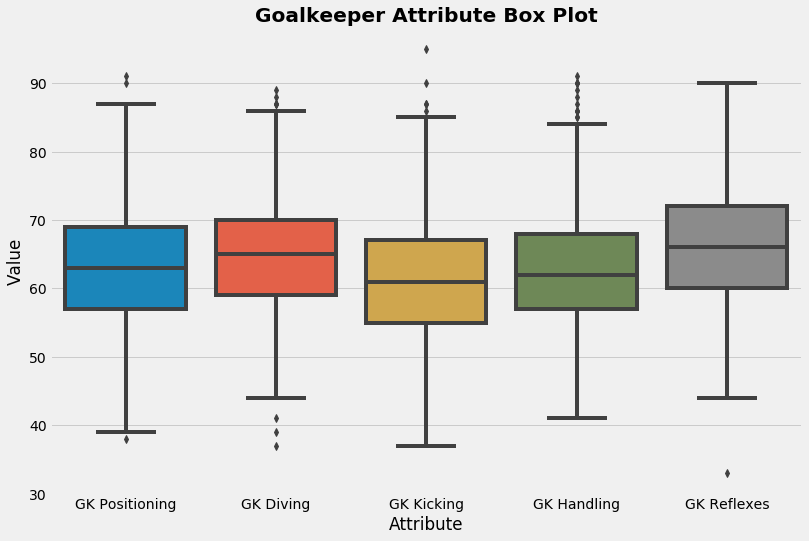

In [122]:
plt.figure(figsize=(12,8))
plt.title('Goalkeeper Attribute Box Plot', loc = 'center', weight = 'bold')
ax = sns.boxplot(x = 'Attribute', y = 'Value', data = df_gks_melt)

In [123]:
df_pl_att = pd.melt(df_players, id_vars = ['Name'], value_vars = shooting_att, var_name = 'Attribute', value_name = 'Value')

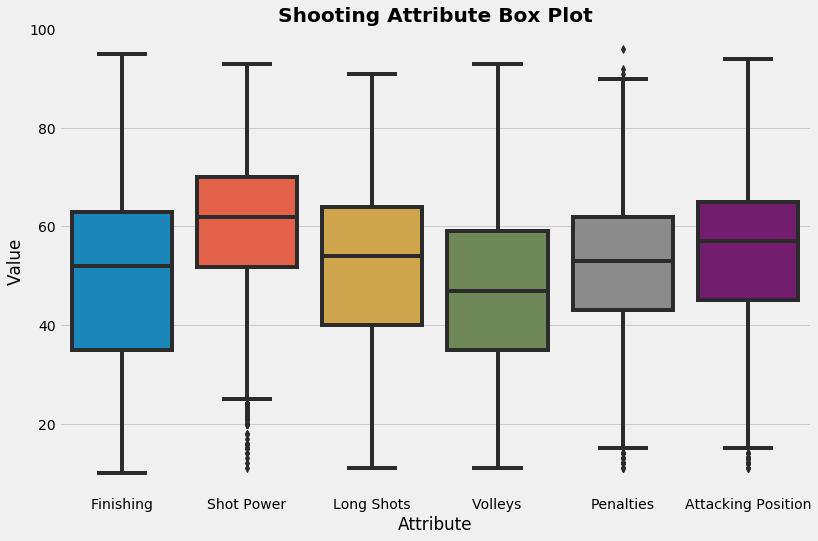

In [124]:
plt.figure(figsize=(12,8))
plt.title('Shooting Attribute Box Plot', loc = 'center', weight = 'bold')
ax = sns.boxplot(x = 'Attribute', y = 'Value', data = df_pl_att)

### Attributes by Position

In [125]:
pos_avgs = df_players.groupby('Position').mean()

Sort table using a manually defined sort: most attacking players to least.

In [126]:
positions = ['ST', 'RW', 'RM','LW', 'LM', 'CAM', 'CM', 'CDM', 'RB','LB', 'CB']
mapping = {pos: i for i, pos in enumerate(positions)}
pos_avgs['sorted'] = pos_avgs.index.map(mapper=(lambda x: mapping[x]))
pos_avgs.sort_values(by='sorted', ascending = True, inplace = True)
pos_avgs.head(11)

,Club Kit,Contract Expiry,Rating,Age,Weak foot,Skill Moves,Ball Control,Dribbling,Marking,Sliding Tackle,...,Jumping,Heading,Shot Power,Finishing,Long Shots,Curve,Freekick Accuracy,Penalties,Volleys,sorted
Position,,,,,,,,,,,,,,,,,,,,,
ST,23.599085,2018.935976,66.087652,25.234375,3.071646,2.624238,64.382241,63.211509,22.611662,23.028963,...,67.606326,63.594893,66.708079,66.811738,59.872713,51.948552,45.398628,63.637195,58.903963,0
RW,23.803419,2019.176638,66.390313,23.455840,3.105413,3.094017,68.142450,69.860399,27.643875,30.022792,...,58.843305,49.202279,65.301994,61.891738,58.558405,58.561254,51.475783,58.472934,55.586895,1
RM,21.303554,2018.887608,66.645533,25.020173,3.146013,2.951009,66.963497,68.541787,34.040346,35.618636,...,62.169068,48.952930,63.867435,59.238232,58.698367,58.784822,52.512008,57.227666,53.980788,2
LW,23.860927,2018.917219,67.304636,24.165563,3.235099,3.102649,69.142384,71.072848,28.019868,29.791391,...,60.324503,50.013245,66.298013,62.417219,60.331126,60.172185,52.754967,58.960265,57.119205,3
LM,22.529781,2018.932079,66.980146,25.000000,3.129572,2.965517,67.626959,69.118077,33.471264,35.336468,...,61.612330,48.885057,64.589342,59.398119,59.081505,60.331243,54.065831,57.349007,54.355277,4
CAM,23.098361,2018.989982,67.184882,24.908925,3.211293,3.067395,68.720401,68.520036,36.093807,37.940801,...,59.994536,49.832423,63.822404,59.224954,60.708561,61.892532,58.746812,59.067395,55.592896,5
CM,20.782543,2018.857719,65.234107,24.784057,3.088799,2.504541,66.554995,63.682139,51.709889,54.721998,...,63.032795,52.725025,63.674571,51.771443,58.315338,56.661453,54.452573,54.545913,50.540363,6
CDM,19.868919,2019.026351,67.294595,26.231081,2.991892,2.193243,65.049324,59.493919,62.981081,63.445270,...,66.486486,58.304730,62.298649,45.199324,54.241216,50.980405,49.751351,51.813514,44.627027,7
RB,20.451909,2018.805516,65.871994,25.509901,2.905233,2.190948,61.109618,59.767327,63.359972,65.765912,...,67.937058,56.022631,52.706506,38.963932,43.924328,49.257426,41.591938,45.803395,39.047383,8


In [127]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [128]:
len(pos_avgs.columns)

36

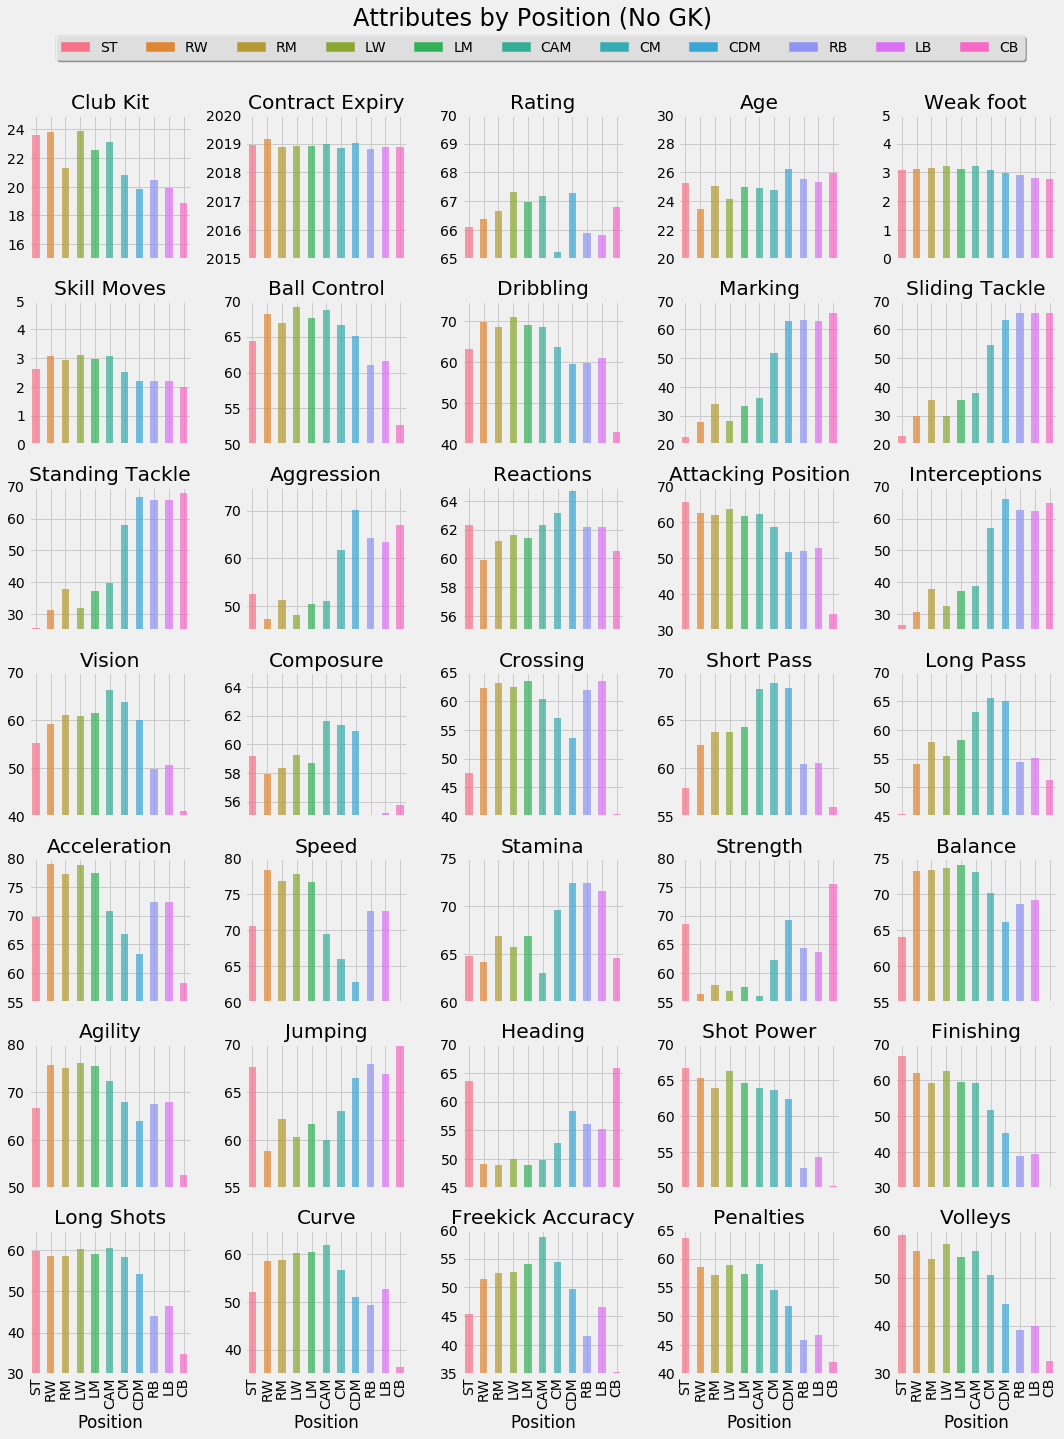

In [129]:
fig, axs = plt.subplots(nrows = 7,ncols = 5, figsize=(15,20), sharex = True)

plt.suptitle('Attributes by Position (No GK)', fontsize = 24, y = 1.)

y_axis_list = list(pos_avgs.columns)[:len(pos_avgs.columns)-1]
for i, col in enumerate(y_axis_list):
    row_num = i // 5
    col_num = i % 5
    max = pos_avgs[col].max()
    max = math.ceil(max/5)*5
    min = pos_avgs[col].min()
    min = math.floor(min/5)*5

    axs[row_num, col_num].set_ylim(min, max)
    pos_avgs[col].plot(kind='bar',
        ax = axs[row_num, col_num], color = sns.color_palette("husl", 11),
            title = col, alpha = 0.7)

        
patch_list = []
colors = sns.color_palette('husl', 11)

for i in range(len(positions)):
    patch_list.append(mpatches.Patch(color = colors[i], label = positions[i]))

plt.figlegend(handles = patch_list, labels = positions, loc = 'upper center',
              ncol = 11, bbox_to_anchor = (.5,.98), shadow = True)

plt.tight_layout()
plt.subplots_adjust(top = .925)

plt.savefig('attributes_by_position.png')

### Attributes by Nationality

In [130]:
df_nation = df_players.groupby(by='Nationality').mean()
count = df_players.groupby(by='Nationality')['Name'].count()
count.name = 'Count'
df_nation = pd.concat([df_nation, count], axis = 1, join_axes = [df_nation.index])
df_nation = df_nation[df_nation['Count']>100]

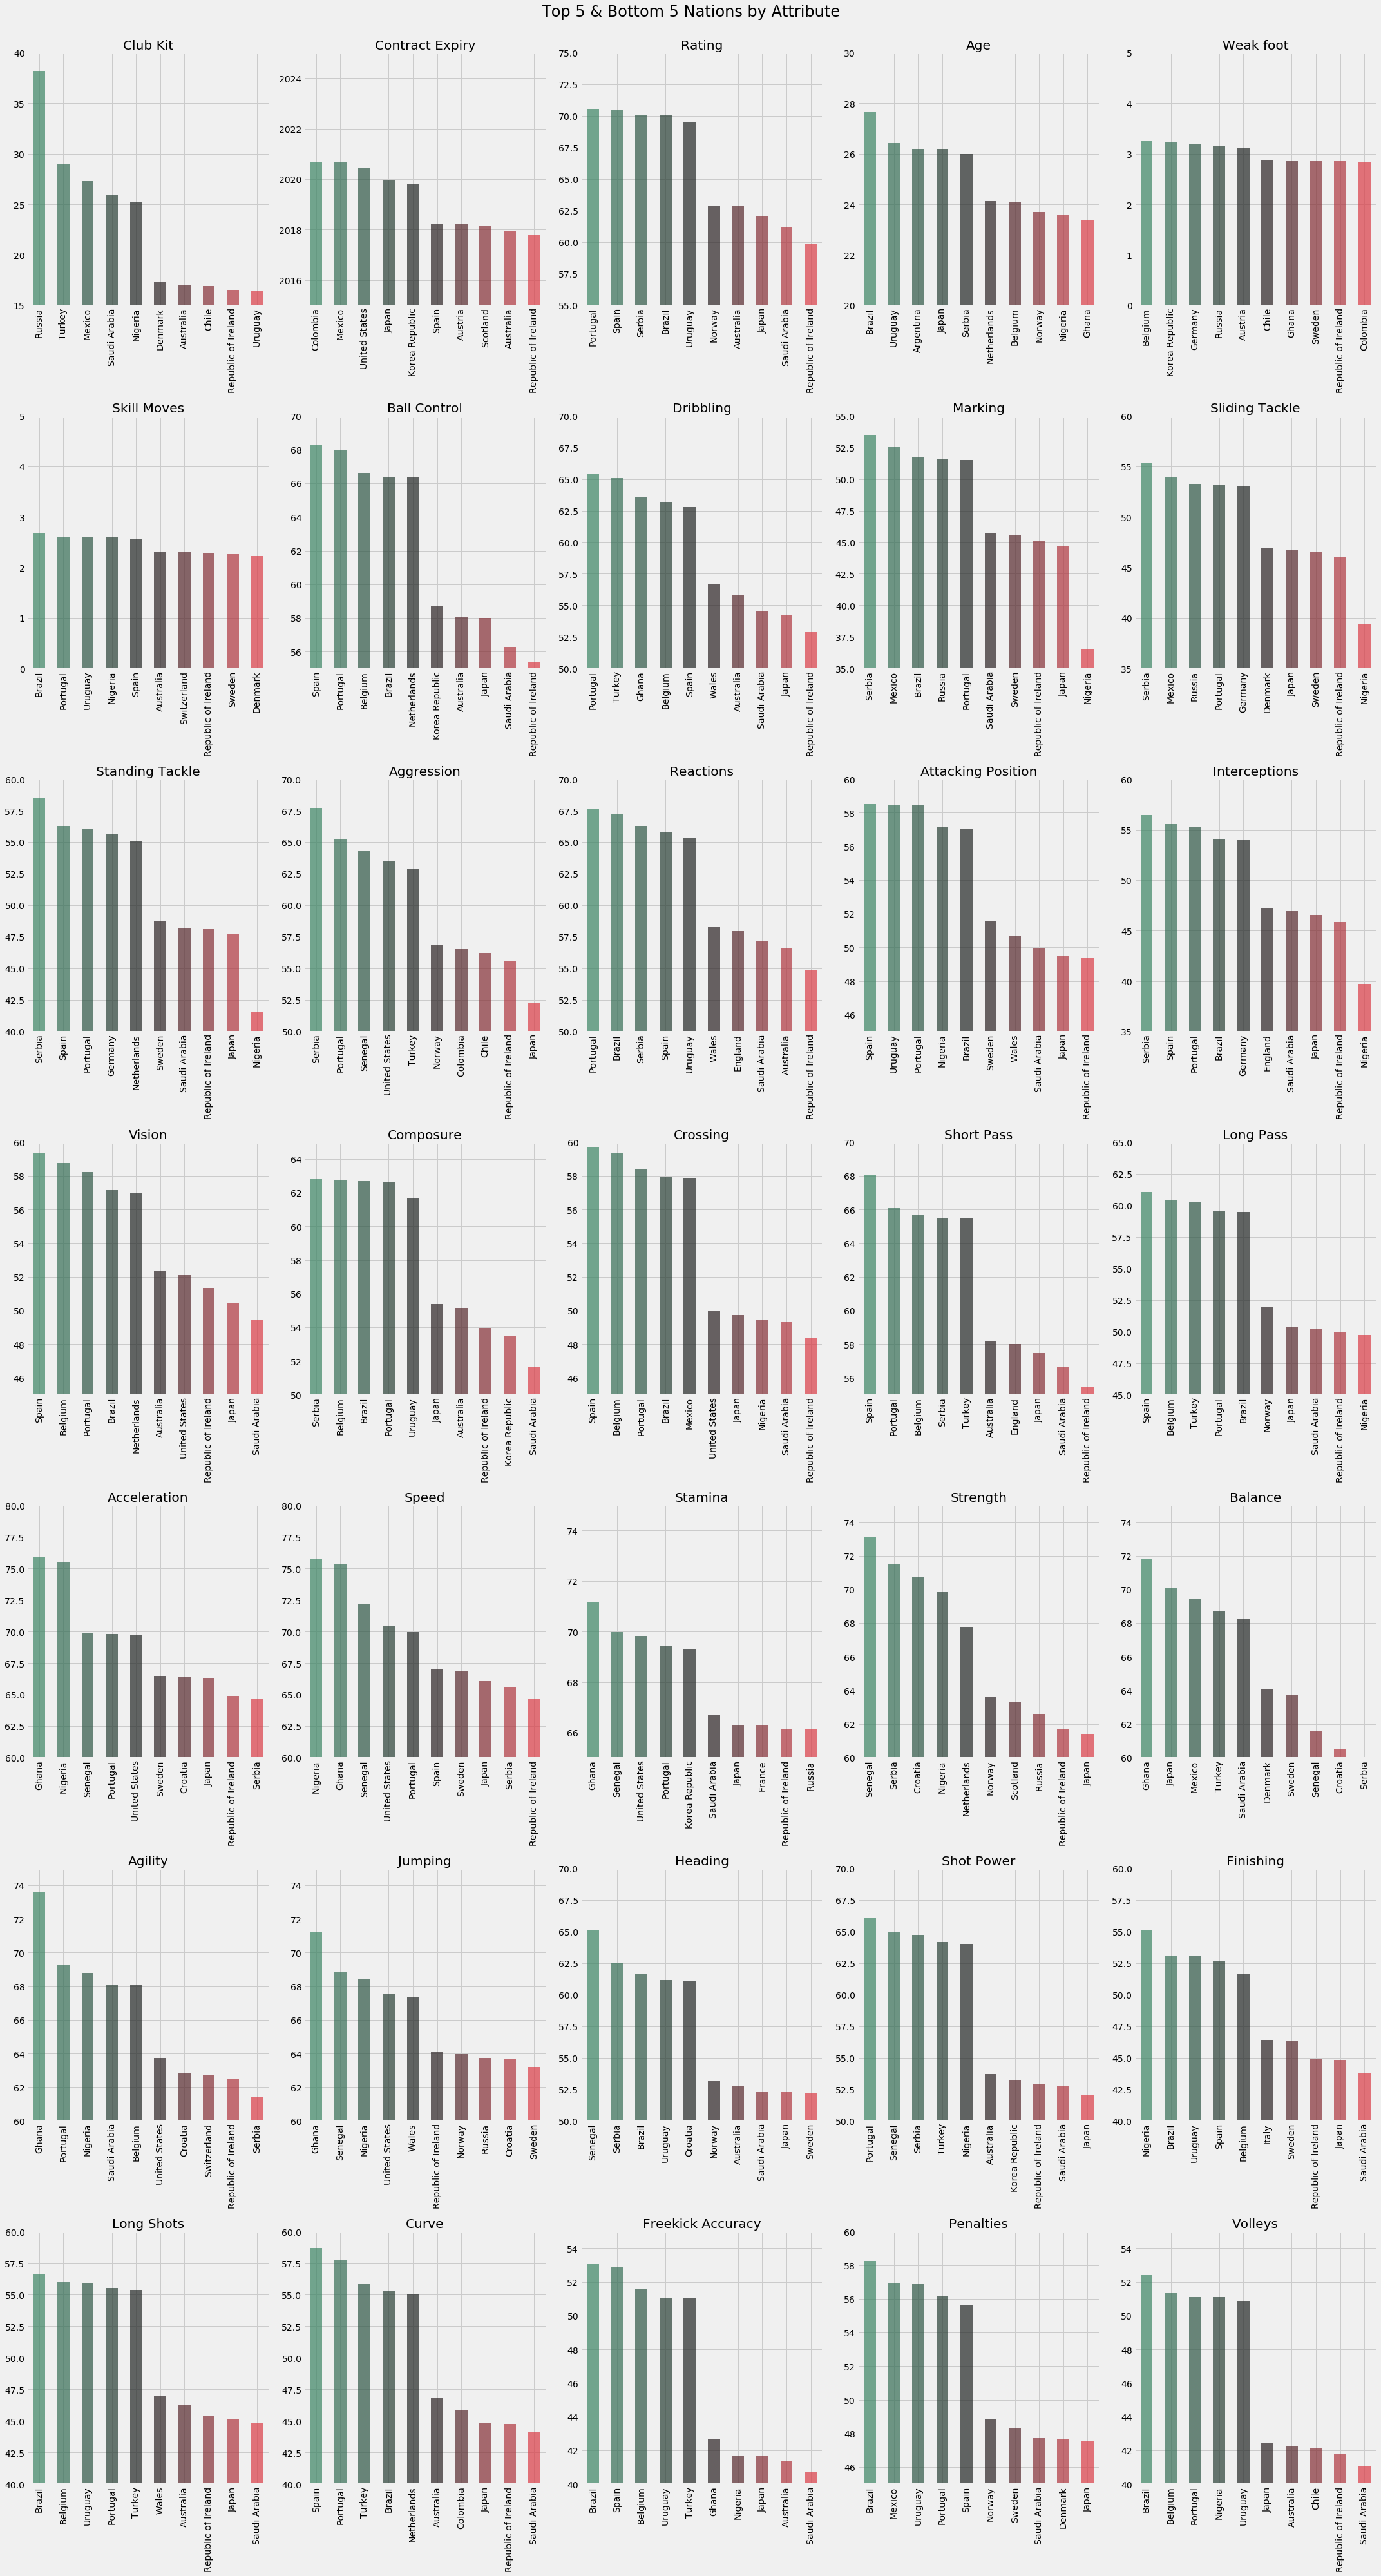

In [131]:
columns = list(df_nation.columns)[:len(df_nation.columns)-1]

fig, axs = plt.subplots(nrows = 7,ncols = 5, figsize=(30,55))
plt.suptitle('Top 5 & Bottom 5 Nations by Attribute', fontsize = 24, y=1.01)

i = 0
for col in columns:
    temp_sort = df_nation.sort_values(by=col, ascending = False)[col]
    temp_top = temp_sort.head(5)
    temp_bot = temp_sort.tail(5)
    temp = pd.concat([temp_top, temp_bot])
    
    nmax = temp.head(1)
    nmax = math.ceil(nmax/5)*5
    nmin = temp.tail(1)
    nmin = math.floor(nmin/5)*5
   
    nrow = i//5
    ncol = i%5
    i = i + 1
    
    axs[nrow, ncol].set_ylim(nmin, nmax)
    
    temp.plot(kind='bar', ax = axs[nrow, ncol], color = sns.diverging_palette(150,10, n = 10, sep = 14, center = 'dark'),
            title = col, alpha = 0.7)
    
    axs[nrow, ncol].get_xaxis().get_label().set_visible(False)
    
plt.subplots_adjust(top = .7)
plt.tight_layout()
    

In [132]:
df_nation_rank = df_nation.rank(ascending = False)
df_nation_rank.head(10)

,Club Kit,Contract Expiry,Rating,Age,Weak foot,Skill Moves,Ball Control,Dribbling,Marking,Sliding Tackle,...,Jumping,Heading,Shot Power,Finishing,Long Shots,Curve,Freekick Accuracy,Penalties,Volleys,Count
Nationality,,,,,,,,,,,,,,,,,,,,,
Argentina,29.0,8.0,14.0,3.0,29.0,7.0,14.0,12.0,22.0,23.0,...,14.0,7.0,15.0,10.0,11.0,11.0,10.0,8.0,17.0,2.0
Australia,32.0,34.0,32.0,29.0,23.0,31.0,32.0,32.0,19.0,22.0,...,29.0,32.0,31.0,27.0,32.0,31.0,34.0,28.0,32.0,27.0
Austria,12.0,32.0,22.0,24.0,5.0,21.0,22.0,22.0,20.0,20.0,...,28.0,19.0,23.0,19.0,20.0,16.0,19.0,27.0,22.0,25.0
Belgium,6.0,23.0,8.0,32.0,1.0,6.0,3.0,4.0,25.0,21.0,...,10.0,17.0,8.0,5.0,2.0,9.0,3.0,9.0,2.0,26.0
Brazil,27.0,9.0,4.0,1.0,18.0,1.0,4.0,6.0,3.0,8.0,...,30.0,3.0,6.0,2.0,1.0,4.0,1.0,1.0,1.0,5.0
Chile,33.0,6.0,20.0,19.0,31.0,10.0,20.0,19.0,13.0,19.0,...,23.0,24.0,27.0,29.0,23.0,29.0,21.0,26.0,33.0,12.0
Colombia,28.0,1.0,19.0,17.0,35.0,11.0,25.0,24.0,26.0,30.0,...,7.0,21.0,28.0,22.0,25.0,32.0,29.0,25.0,28.0,8.0
Croatia,9.0,13.5,7.0,18.0,8.0,14.0,16.0,17.0,16.0,11.0,...,34.0,5.0,18.0,15.0,16.0,19.0,14.0,15.0,15.0,35.0
Denmark,31.0,17.0,28.0,25.0,14.0,35.0,23.0,30.0,30.0,31.0,...,27.0,25.0,25.0,26.0,28.0,25.0,26.0,34.0,24.0,17.0


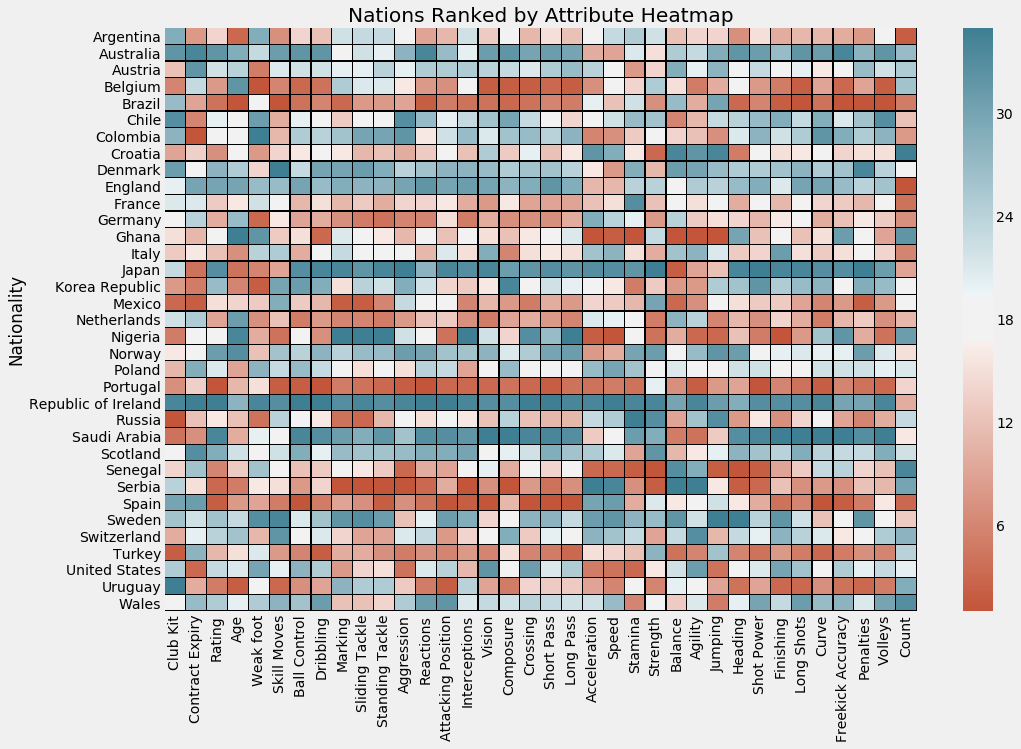

In [133]:
plt.figure(figsize = (15,10))
plt.title('Nations Ranked by Attribute Heatmap')
cmap = sns.diverging_palette(20, 220, sep=20, as_cmap=True)
ax = sns.heatmap(df_nation_rank, center = 18, cmap = cmap, vmin = 1, vmax = 35, robust = True,
                 linewidths = 0.25, linecolor = 'black')

## Teaching of the Machines

Machine learning is the subfield of computer science that, according to Arthur Samuel, gives "computers the ability to learn without being explicitly programmed."

Evolved from the study of pattern recognition and computational learning theory in artificial intelligence, machine learning explores the study and construction of algorithms that can learn from and make predictions on data – such algorithms overcome following strictly static program instructions by making data-driven predictions or decisions, through building a model from sample inputs. Machine learning is employed in a range of computing tasks where designing and programming explicit algorithms with good performance is difficult or infeasible; example applications include email filtering, detection of network intruders or malicious insiders working towards a data breach, optical character recognition (OCR), learning to rank, and computer vision.

### Supervised Learning: Regression

Supervised learning: The computer is presented with example inputs and their desired outputs, given by a "teacher", and the goal is to learn a general rule that maps inputs to outputs.

In statistical modeling, regression analysis is a set of statistical processes for estimating the relationships among variables. It includes many techniques for modeling and analyzing several variables, when the focus is on the relationship between a dependent variable and one or more independent variables (or 'predictors'). More specifically, regression analysis helps one understand how the typical value of the dependent variable (or 'criterion variable') changes when any one of the independent variables is varied, while the other independent variables are held fixed.

In [207]:
atts = list(df_players.columns)[16:len(df_players.columns)-1]

y_frame = df_players['Rating']
x_frame = df_players.loc[:,'Ball Control':'Volleys']

regr = linear_model.LinearRegression()
regr.fit(x_frame, y_frame)
y_pred = regr.predict(x_frame)
    
coefs = regr.coef_
mean_squared = mean_squared_error(y_frame, y_pred)
r_squared = r2_score(y_frame, y_pred)

base_coef_dict = {}
for i, att in enumerate(atts):
    print('{}: {}'.format(att, coefs[i]))
    base_coef_dict[att] = coefs[i]

base_coef = pd.DataFrame(base_coef_dict, index = [0])
print('Mean Squared Error: {:.4f}'.format(mean_squared))
print('R-squared: {:.4f}'.format(r_squared))
print('----------------------------------------')


Ball Control: 0.1994550843798497
Dribbling: 0.0033232967294615622
Marking: 0.015417648237736128
Sliding Tackle: -0.026606963155246
Standing Tackle: 0.042486836434242586
Aggression: 0.0053683814042992
Reactions: 0.26956645891999786
Attacking Position: -0.04881052556076198
Interceptions: 0.010516545011814215
Vision: -0.03164044517832523
Composure: 0.06320220968251652
Crossing: 0.020087072944332103
Short Pass: 0.097785785923592
Long Pass: -0.018457499933569044
Acceleration: 0.041849527380074664
Speed: 0.037405543558943044
Stamina: 0.006490377976156918
Strength: 0.057716995493877474
Balance: -0.012879082166770625
Agility: 0.002340903818097202
Jumping: 0.011457160900869068
Heading: 0.10053569841990409
Shot Power: 0.01299264035642167
Finishing: 0.03155114014646252
Long Shots: -0.020339429153455057
Curve: 0.011749657357931355
Freekick Accuracy: 0.008772964569818964
Penalties: 0.010550281190951305
Volleys: -0.0007183353455059369
Mean Squared Error: 7.4365
R-squared: 0.8461
--------------------

In [198]:
ret_dict = {}

for pos in positions:
    temp = df_players[df_players['Position'] == pos]
    y_temp = temp['Rating']
    x_temp = temp.loc[:,'Ball Control':'Volleys']
    
    reg = linear_model.LinearRegression()
    reg.fit(x_temp, y_temp)
    y_pred = reg.predict(x_temp)
    
    coefs = reg.coef_
    mean_squared = mean_squared_error(y_temp, y_pred)
    r_squared = r2_score(y_temp, y_pred)
    
    print('Position: {}'.format(pos))
    
    ret_dict[pos] = {}
    ret_dict[pos]['R2'] = r_squared
    ret_dict[pos]['Mean Squared Error'] = mean_squared
    for i, att in enumerate(atts):
        ret_dict[pos][att] = coefs[i]
        
    print('Mean Squared Error: {:.4f}'.format(mean_squared))
    print('R-squared: {:.4f}'.format(r_squared))
    print('----------------------------------------')
    
regression = pd.DataFrame(ret_dict)
regression = regression.T
regression
    

Position: ST
Mean Squared Error: 0.2500
R-squared: 0.9950
----------------------------------------
Position: RW
Mean Squared Error: 0.1268
R-squared: 0.9976
----------------------------------------
Position: RM
Mean Squared Error: 0.0969
R-squared: 0.9977
----------------------------------------
Position: LW
Mean Squared Error: 0.1874
R-squared: 0.9962
----------------------------------------
Position: LM
Mean Squared Error: 0.1018
R-squared: 0.9976
----------------------------------------
Position: CAM
Mean Squared Error: 0.1238
R-squared: 0.9974
----------------------------------------
Position: CM
Mean Squared Error: 0.1306
R-squared: 0.9979
----------------------------------------
Position: CDM
Mean Squared Error: 0.1062
R-squared: 0.9974
----------------------------------------
Position: RB
Mean Squared Error: 0.1186
R-squared: 0.9972
----------------------------------------
Position: LB
Mean Squared Error: 0.1120
R-squared: 0.9973
----------------------------------------
Position

,Acceleration,Aggression,Agility,Attacking Position,Balance,Ball Control,Composure,Crossing,Curve,Dribbling,...,Reactions,Short Pass,Shot Power,Sliding Tackle,Speed,Stamina,Standing Tackle,Strength,Vision,Volleys
CAM,0.038593,0.001421,0.030383,0.090641,-0.003395,0.144523,0.003247,-0.000455,0.000600,0.130360,...,0.073290,0.168611,-0.001179,-0.001226,0.033290,-0.000471,0.000799,0.000591,0.140594,0.000351
CB,0.001664,0.066931,-0.000748,-0.001054,-0.000011,0.040934,-0.000420,-0.000853,-0.000249,0.001081,...,0.051247,0.048870,-0.001423,0.103030,0.019856,0.001351,0.171069,0.099149,0.000875,0.001210
CDM,0.000696,0.048419,-0.003525,-0.001910,0.002664,0.100364,0.001095,-0.000253,-0.001685,0.001330,...,0.070755,0.142705,-0.000809,0.050332,0.001242,0.058282,0.122617,0.039673,0.040026,0.000524
CM,0.001299,-0.001861,-0.000775,0.059499,-0.000201,0.140284,0.000309,-0.001828,-0.002337,0.074118,...,0.087938,0.173307,-0.002182,0.000738,-0.001452,0.060092,0.049996,0.000935,0.128098,0.001777
LB,0.050827,-0.001647,-0.003934,-0.003329,0.000242,0.073358,0.001151,0.087792,-0.001894,0.002388,...,0.084230,0.070118,-0.000805,0.140899,0.072813,0.077573,0.111346,-0.001028,0.001544,-0.001189
LM,0.071066,-0.002809,-0.000096,0.084799,-0.000056,0.131856,-0.001604,0.100105,-0.003464,0.149597,...,0.074201,0.107414,-0.002031,-0.000101,0.059621,0.048698,0.002642,0.003816,0.067606,0.002166
LW,0.071490,0.003871,0.039682,0.098478,-0.005446,0.138577,-0.005794,0.091241,-0.003177,0.168226,...,0.065723,0.094089,-0.003893,0.003454,0.051131,0.004644,0.000322,-0.003289,0.063405,0.002794
RB,0.048138,-0.003651,-0.001018,-0.003346,0.002656,0.073103,0.000710,0.091136,0.001549,0.000107,...,0.085900,0.070618,-0.001399,0.142695,0.070710,0.079117,0.107770,0.001745,0.000332,-0.000493
RM,0.071895,0.000600,-0.003470,0.079866,0.001685,0.128534,-0.000032,0.097936,-0.000310,0.150440,...,0.070558,0.111530,-0.000474,0.004623,0.059979,0.048209,-0.001114,0.000397,0.068936,0.001103
RW,0.075795,-0.001731,0.021644,0.089269,0.001544,0.142840,0.004872,0.088648,-0.001690,0.165846,...,0.072146,0.094004,-0.000244,0.001341,0.056475,-0.000060,-0.004049,-0.001666,0.058622,-0.000751


In [212]:
regression_coef = regression.drop('Mean Squared Error', axis = 1)
regression_coef = regression_coef.drop('R2', axis = 1)
print(regression_coef.shape)
print(base_coef.shape)

(11, 29)
(1, 29)


In [222]:
diff = pd.DataFrame(data = regression_coef.values - base_coef.values, columns = regression_coef.columns,
                   index = regression_coef.index)

In [223]:
diff

,Acceleration,Aggression,Agility,Attacking Position,Balance,Ball Control,Composure,Crossing,Curve,Dribbling,...,Reactions,Short Pass,Shot Power,Sliding Tackle,Speed,Stamina,Standing Tackle,Strength,Vision,Volleys
CAM,-0.003257,-0.003947,0.028042,0.139451,0.009484,-0.054932,-0.059955,-0.020542,-0.011149,0.127036,...,-0.196276,0.070826,-0.014171,0.025381,-0.004115,-0.006961,-0.041688,-0.057126,0.172234,0.001069
CB,-0.040186,0.061563,-0.003089,0.047756,0.012869,-0.158521,-0.063622,-0.020940,-0.011999,-0.002243,...,-0.218320,-0.048915,-0.014416,0.129637,-0.017549,-0.005139,0.128582,0.041432,0.032515,0.001929
CDM,-0.041154,0.043050,-0.005866,0.046901,0.015544,-0.099091,-0.062108,-0.020340,-0.013434,-0.001993,...,-0.198811,0.044919,-0.013802,0.076939,-0.036164,0.051792,0.080130,-0.018043,0.071666,0.001243
CM,-0.040550,-0.007229,-0.003116,0.108310,0.012678,-0.059171,-0.062893,-0.021915,-0.014086,0.070794,...,-0.181629,0.075521,-0.015174,0.027345,-0.038857,0.053602,0.007509,-0.056782,0.159738,0.002495
LB,0.008978,-0.007016,-0.006275,0.045481,0.013122,-0.126097,-0.062051,0.067705,-0.013644,-0.000935,...,-0.185337,-0.027667,-0.013797,0.167505,0.035408,0.071082,0.068859,-0.058745,0.033184,-0.000470
LM,0.029216,-0.008178,-0.002437,0.133610,0.012823,-0.067599,-0.064806,0.080018,-0.015214,0.146274,...,-0.195365,0.009628,-0.015023,0.026506,0.022216,0.042207,-0.039845,-0.053901,0.099246,0.002884
LW,0.029641,-0.001497,0.037341,0.147288,0.007433,-0.060878,-0.068996,0.071154,-0.014927,0.164903,...,-0.203843,-0.003697,-0.016886,0.030061,0.013725,-0.001847,-0.042165,-0.061006,0.095045,0.003512
RB,0.006288,-0.009019,-0.003359,0.045465,0.015535,-0.126352,-0.062492,0.071049,-0.010201,-0.003216,...,-0.183666,-0.027168,-0.014392,0.169302,0.033304,0.072627,0.065283,-0.055972,0.031972,0.000226
RM,0.030046,-0.004768,-0.005811,0.128677,0.014564,-0.070921,-0.063235,0.077849,-0.012060,0.147116,...,-0.199008,0.013744,-0.013467,0.031230,0.022574,0.041719,-0.043601,-0.057320,0.100576,0.001822
RW,0.033945,-0.007099,0.019303,0.138080,0.014423,-0.056615,-0.058330,0.068561,-0.013440,0.162523,...,-0.197420,-0.003782,-0.013236,0.027947,0.019070,-0.006551,-0.046536,-0.059383,0.090263,-0.000033


### Dimensionality Reduction: Principal Component Analysis (PCA)

In machine learning and statistics, dimensionality reduction or dimension reduction is the process of reducing the number of random variables under consideration, via obtaining a set of principal variables. It can be divided into feature selection and feature extraction.

Feature selection approaches try to find a subset of the original variables (also called features or attributes). There are three strategies; filter (e.g. information gain) and wrapper (e.g. search guided by accuracy) approaches, and embedded (features are selected to add or be removed while building the model based on the prediction errors). See also combinatorial optimization problems.

In some cases, data analysis such as regression or classification can be done in the reduced space more accurately than in the original space.

Feature extraction transforms the data in the high-dimensional space to a space of fewer dimensions. The data transformation may be linear, as in principal component analysis (PCA), but many nonlinear dimensionality reduction techniques also exist. For multidimensional data, tensor representation can be used in dimensionality reduction through multilinear subspace learning.

The main linear technique for dimensionality reduction, principal component analysis, performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. In practice, the covariance (and sometimes the correlation) matrix of the data is constructed and the eigen vectors on this matrix are computed. The eigen vectors that correspond to the largest eigenvalues (the principal components) can now be used to reconstruct a large fraction of the variance of the original data. Moreover, the first few eigen vectors can often be interpreted in terms of the large-scale physical behavior of the system. The original space (with dimension of the number of points) has been reduced (with data loss, but hopefully retaining the most important variance) to the space spanned by a few eigenvectors.